In [1]:
from astropy.table import Table
from astropy.cosmology import WMAP7 as cosmo
from astropy.cosmology import FlatLambdaCDM
cosmo_david = FlatLambdaCDM(H0=73, Om0=0.25)

import astropy.units as u

import numpy as np
import pandas as pd

from jpasLAEs.utils import mag_to_flux, flux_to_mag

from paus_utils import *

import matplotlib.pyplot as plt
import matplotlib.colors
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 16})

In [2]:
def load_tab(load_frac=1):
    tab = Table.read('/home/alberto/almacen/PAUS_data/catalogs/LightCone_mock_EL_fluxes.fits').to_pandas()

    r_mag = tab['apprso_tot_ext']
    i_mag = tab['appiso_tot_ext']

    rand_ids = np.random.choice(np.arange(len(tab)), int(len(tab)*load_frac),
                                replace=False)
    tab = tab.iloc[rand_ids]

    r_mag = r_mag[rand_ids]
    i_mag = i_mag[rand_ids]
    mag_mask = (r_mag <= 25) & (i_mag <= 25)

    tab = tab[mag_mask]

    print(tab.dtypes)

    return tab


load_frac = 1/7
tab = load_tab(load_frac=load_frac)

unique_object_id         int32
z_cos                  float32
ew_tot_halpha          float32
ew_tot_halpha_ext      float32
ew_tot_hbeta           float32
ew_tot_hbeta_ext       float32
ew_tot_oii3727         float32
ew_tot_oii3727_ext     float32
ew_tot_oiii4959        float32
ew_tot_oiii4959_ext    float32
ew_tot_oiii5007        float32
ew_tot_oiii5007_ext    float32
l_tot_halpha           float32
l_tot_halpha_ext       float32
l_tot_hbeta            float32
l_tot_hbeta_ext        float32
l_tot_oii3727          float32
l_tot_oii3727_ext      float32
l_tot_oiii4959         float32
l_tot_oiii4959_ext     float32
l_tot_oiii5007         float32
l_tot_oiii5007_ext     float32
z_obs                  float32
appiso_tot_ext         float32
apprso_tot_ext         float32
dtype: object


In [7]:
path_to_mock = '/home/alberto/almacen/PAUS_data/catalogs/LightCone_mock.fits'
tab_cat = Table.read(path_to_mock).to_pandas()

In [3]:
def lines_L_cat(tab):
    line_cat = {}

    line_list = ['halpha', 'hbeta', 'oii3727', 'oiii4959', 'oiii5007']

    for line_name in line_list:
        print(line_name)
        dL_Arr = cosmo.luminosity_distance(tab['z_obs'].to_numpy()).to(u.cm).value
        this_line_L = tab[f'l_tot_{line_name}'] * 4 * np.pi * dL_Arr**2
        this_line_L_ext = tab[f'l_tot_{line_name}_ext'] * 4 * np.pi * dL_Arr**2

        line_cat[f'L_{line_name}'] = this_line_L
        line_cat[f'L_{line_name}_ext'] = this_line_L_ext

    return pd.DataFrame(line_cat)

line_cat = lines_L_cat(tab)


# Add columns with the total OII:
line_cat['L_oiii_tot'] = line_cat['L_oiii4959'] + line_cat['L_oiii5007']
line_cat['L_oiii_tot_ext'] = line_cat['L_oiii4959_ext'] + line_cat['L_oiii5007_ext']

halpha
hbeta
oii3727
oiii4959
oiii5007


In [4]:
def M_to_m(M, redshift):
    dL = cosmo.luminosity_distance(redshift).to(u.pc).value.reshape(-1, 1)
    return M + 5 * np.log10(dL) - 5

def lines_L_cat():
    tab = np.load('/home/alberto/almacen/David_lightcone/LightCone_512_15sep2022.npy')

    M_line = tab['ObsMagDustLine']
    r_mag = M_to_m(M_line, tab['redshift']).T[-2]
    i_mag = M_to_m(M_line, tab['redshift']).T[-1]
    mask_mag = (r_mag <= 25) & (i_mag <= 25)

    line_cat = {}

    line_list = ['Halpha', 'Hbeta', 'OII3727', 'OIII4959', 'OIII5007']

    for line_name in line_list:
        print(line_name)
        dL_Arr = cosmo_david.luminosity_distance(tab['redshift']).to(u.cm).value
        this_line_L = tab[f'Flux_{line_name}'] * 4 * np.pi * dL_Arr**2
        this_line_L_ext = tab[f'FluxDust_{line_name}'] * 4 * np.pi * dL_Arr**2

        line_cat[f'L_{line_name.lower()}'] = this_line_L[mask_mag]
        line_cat[f'L_{line_name.lower()}_ext'] = this_line_L_ext[mask_mag]

    return pd.DataFrame(line_cat), tab['redshift'][mask_mag], r_mag[mask_mag]


david_line_cat, z_david, r_david = lines_L_cat()

Halpha
Hbeta
OII3727
OIII4959
OIII5007


In [5]:
from jpasLAEs.utils import bin_centers, z_volume

L_bins = np.linspace(35, 44, 100)
L_bins_c = bin_centers(L_bins)
L_bins_w = np.array([L_bins[i + 1] - L_bins[i] for i in range(len(L_bins) - 1)])

line_list = ['halpha', 'hbeta', 'oii3727', 'oiii4959', 'oiii5007']

from scipy.integrate import trapezoid

z_bins = np.linspace(0, 1.5, 10)

int_corr_Arr = []

for ii, line_name in enumerate(line_list):
    this_line_corr_Arr = []
    for jj in range(len(z_bins) - 1):
        z_min = z_bins[jj]
        z_max = z_bins[jj + 1]

        z_mask = (tab['z_obs'] >= z_min) & (tab['z_obs'] <= z_max)
        z_mask_david = (z_david >= z_min) & (z_david <= z_max)

        z_vol = z_volume(z_min, z_max, 59.97 * load_frac)
        z_vol_david = z_volume(z_min, z_max, 3)

        L_Arr_to_hist = line_cat[f'L_{line_name}_ext'][z_mask]
        this_LF_ext = np.histogram(np.log10(L_Arr_to_hist),
                            L_bins)[0] / L_bins_w / z_vol

        if line_name == 'oii3727':
            L_Arr_to_hist = david_line_cat[f'L_{line_name}'][z_mask_david]
        else:
            L_Arr_to_hist = david_line_cat[f'L_{line_name}_ext'][z_mask_david]
        this_LF_david_ext = np.histogram(np.log10(L_Arr_to_hist),
                                    L_bins)[0] / L_bins_w / z_vol_david


        L_min = np.max([np.max(this_LF_ext), np.max(this_LF_david_ext)])

        L_mask = ((L_bins_c > L_min))
                #   & (this_LF_david_ext > 1e-5) & (this_LF_david_ext < 1e-3))
        int_top = trapezoid(this_LF_david_ext[L_mask], 10 ** L_bins_c[L_mask])

        L_mask = ((L_bins_c > L_min))
                #   & (this_LF_ext > 1e-5) & (this_LF_ext < 1e-3))
        int_bot = trapezoid(this_LF_ext[L_mask], 10 ** L_bins_c[L_mask])
        
        this_line_corr_Arr.append(int_top / int_bot)

    int_corr_Arr.append(this_line_corr_Arr)


# Enga ponlo bonito para guardarlo bien
int_corr_dict = {}
for kkk, line_name in enumerate(line_list):
    int_corr_dict[f'{line_name}_corr_factor'] = int_corr_Arr[kkk]

int_corr_dict['z_bins'] = z_bins

import pickle

with open('/home/alberto/almacen/PAUS_data/catalogs/Lightcone_line_corr.pkl', 'wb') as f:
    pickle.dump(int_corr_dict, f)

/home/alberto/miniconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.3333333333333333 0.5


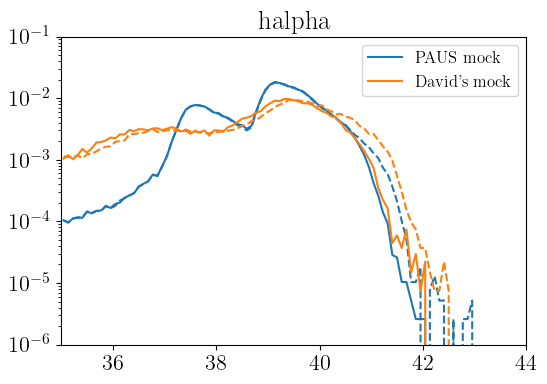

/home/alberto/miniconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


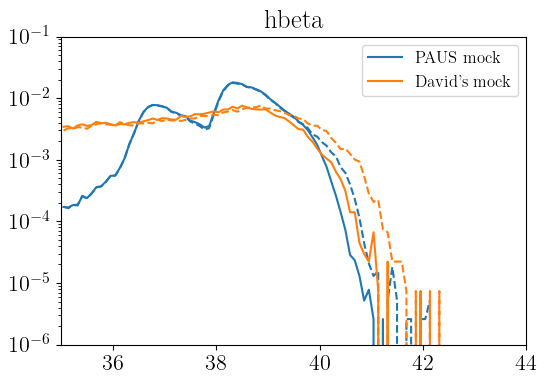

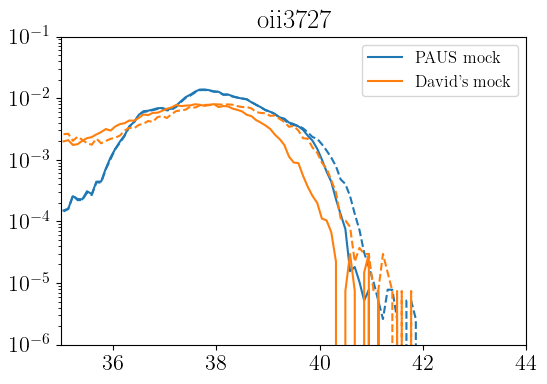

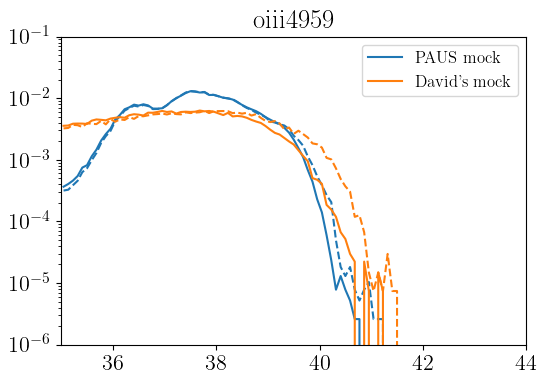

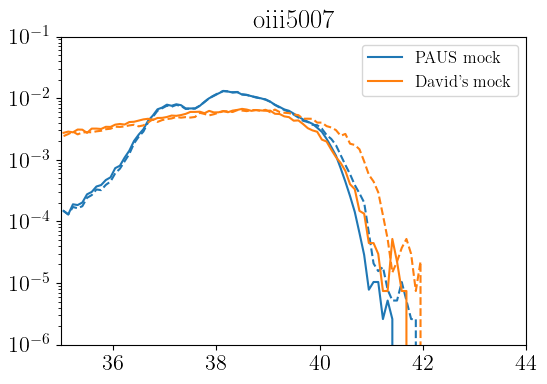

In [6]:
z_bin_i = 2

###### Define z interval
z_min, z_max = z_bins[z_bin_i], z_bins[z_bin_i + 1]
z_mask = (tab['z_obs'] >= z_min) & (tab['z_obs'] <= z_max)
z_mask_david = (z_david >= z_min) & (z_david <= z_max)
print(z_min, z_max)

z_vol = z_volume(z_min, z_max, 59.97 * load_frac)
z_vol_david = z_volume(z_min, z_max, 3)


for ii, line_name in enumerate(line_list):
    correct_factor = int_corr_Arr[ii][z_bin_i]

    fig, ax = plt.subplots(figsize=(6, 4))

    L_Arr_to_hist = line_cat[f'L_{line_name}'][z_mask] * correct_factor
    this_LF = np.histogram(np.log10(L_Arr_to_hist),
                        L_bins)[0] / L_bins_w / z_vol
    L_Arr_to_hist = line_cat[f'L_{line_name}_ext'][z_mask] * correct_factor
    this_LF_ext = np.histogram(np.log10(L_Arr_to_hist),
                        L_bins)[0] / L_bins_w / z_vol

    L_Arr_to_hist = david_line_cat[f'L_{line_name}'][z_mask_david]
    this_LF_david = np.histogram(np.log10(L_Arr_to_hist),
                                 L_bins)[0] / L_bins_w / z_vol_david
    L_Arr_to_hist = david_line_cat[f'L_{line_name}_ext'][z_mask_david]
    this_LF_david_ext = np.histogram(np.log10(L_Arr_to_hist),
                                 L_bins)[0] / L_bins_w / z_vol_david

    ax.plot(L_bins_c, this_LF, color=f'C0', ls='--')
    ax.plot(L_bins_c, this_LF_ext, color=f'C0', label='PAUS mock')

    ax.plot(L_bins_c, this_LF_david, color=f'C1', ls='--')
    ax.plot(L_bins_c, this_LF_david_ext, color=f'C1', label='David\'s mock')

    
    ax.set(yscale='log',
        ylim=(1e-6, 1e-1), xlim=(35, 44))

    ax.legend(fontsize=12)
    ax.set_title(line_name)

    plt.show()